In [2]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 24kB/s 
     |████████████████████████████████| 450kB 50.6MB/s 
     |████████████████████████████████| 3.9MB 55.8MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=c7e9f97f8aaef812864c9e8d62b24e914608541a339b3ea8963ea5bdc5bd469f
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [ ]:
!pip install keras==2.3.1

In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from gensim.corpora.dictionary import Dictionary
from keras.preprocessing.text import Tokenizer, one_hot

In [ ]:
!pip install plot_keras_history

In [ ]:
fullines= pd.read_csv('drive/My Drive/Colab Data/kopitiam.csv', header = 0)



#Any pairwise and sequence data can be processed
#Not only for translation OR Everything is "translation"
#For example: 
  #Question , Answer pairs
  #Image , caption pairs
  #song , lyric pairs


In [ ]:
#Data Preprocessing 
#Will differ according to the nature of the data. 
#This step is important!!! and time consuming!!!!

#Lowercase
fullines.SeqA=fullines.SeqA.apply(lambda x: x.lower())
fullines.SeqB=fullines.SeqB.apply(lambda x: x.lower())

#remove digits
remove_digits = str.maketrans('', '', digits)
fullines.SeqA=fullines.SeqA.apply(lambda x: x.translate(remove_digits))
fullines.SeqB=fullines.SeqB.apply(lambda x: x.translate(remove_digits))

#Special for Decoder SeqB
fullines.SeqB = fullines.SeqB.apply(lambda x : '$START '+ x + ' END$')

fullines.head()

lines, testlines =  train_test_split(fullines, train_size = 0.8,random_state=9)



In [ ]:
#tokenize and index the sequence A

tokenizer_A = Tokenizer()
tokenizer_A.fit_on_texts(lines.SeqA)

seqA = tokenizer_A.texts_to_sequences(lines.SeqA)
print(seqA[0:10])
word_index_A = tokenizer_A.word_index

vocab_size_A = len(word_index_A) + 1  # Adding 1 because of reserved 0 index by Tokenizer
maxlen_A = max(len(x) for x in seqA) # longest text in train set
print('vocabubary size:',vocab_size_A)
print('max length text:',maxlen_A)


[[1, 5], [1, 7], [2, 4], [1, 6], [1, 7, 10, 3], [1, 7], [2, 29], [2, 6], [2, 6], [1, 4, 5]]
vocabubary size: 63
max length text: 5


In [ ]:
#tokenize and index the sequence B

tokenizer_B = Tokenizer(filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',)
tokenizer_B.fit_on_texts(lines.SeqB)

seqB = tokenizer_B.texts_to_sequences(lines.SeqB)
print(seqB[0:10])
word_index_B = tokenizer_B.word_index

print(word_index_B)

vocab_size_B = len(word_index_B) + 1  # Adding 1 because of reserved 0 index by Tokenizer
maxlen_B = max(len(x) for x in seqB) # longest text in train set
print('vocabubary size:',vocab_size_B)
print('max length text:',maxlen_B)

[[1, 12, 5, 15, 6, 22, 4, 2], [1, 23, 5, 3, 9, 4, 2], [1, 7, 3, 6, 28, 2], [1, 12, 5, 3, 13, 4, 2], [1, 10, 5, 3, 9, 4, 8, 11, 5, 14, 8, 11, 6, 2], [1, 10, 5, 3, 9, 4, 8, 6, 8, 11, 5, 14, 2], [1, 7, 3, 13, 4, 2], [1, 10, 7, 3, 13, 4, 8, 6, 2], [1, 7, 3, 13, 4, 8, 6, 40, 17, 9, 4, 2], [1, 5, 15, 6, 22, 4, 2]]
{'$start': 1, 'end$': 2, 'with': 3, 'milk': 4, 'coffee': 5, 'sugar': 6, 'tea': 7, 'and': 8, 'condensed': 9, 'hot': 10, 'more': 11, 'black': 12, 'evaporated': 13, 'powder': 14, 'without': 15, 'lesser': 16, 'of': 17, 'less': 18, 'iced': 19, 'water': 20, 'milo': 21, 'or': 22, 'strong': 23, 'but': 24, 'the': 25, 'no': 26, 'added': 27, 'only': 28, 'brew': 29, 'a': 30, 'to': 31, 'version': 32, 'initial': 33, 'ice': 34, 'weaker': 35, 'horlicks': 36, 'pulled': 37, 'is': 38, 'ginger': 39, 'instead': 40, 'they': 41, 'add': 42, 'iced\xa0tea': 43, 'heaviest': 44, 'purest': 45, 'at': 46, 'all': 47, 'simply': 48, 'any': 49, 'kind': 50, 'weak': 51, 'thicker': 52, 'robust': 53, 'for': 54, 'heavier

In [ ]:
# seqA_vec -> encoder -> seqB_vec -> decoder -> seqB_one-hot-matrix (ahead by one timestep)

# First define the vectors' shape with all 0s as value
encoder_input_data = np.zeros((len(seqA), maxlen_A), dtype='float32')
decoder_input_data = np.zeros((len(seqB), maxlen_B), dtype='float32')
decoder_target_data = np.zeros((len(seqB), maxlen_B, vocab_size_B),dtype='float32')


In [ ]:
#Then populate the word_index as the value
for i, (input_text, target_text) in enumerate(zip(seqA, seqB)):
    for t, word_id in enumerate(input_text):
        encoder_input_data[i, t] = word_id
    for t, word_id in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = word_id
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, word_id] = 1.0


In [ ]:
#check the index for the first pair 
print("encoder:")
print(encoder_input_data[0])
print(decoder_input_data[0])
print("target:")
print(decoder_target_data[0,0])
print(decoder_target_data[0,1])
print(decoder_target_data[0,2])

encoder:
[1. 5. 0. 0. 0.]
[ 1. 12.  5. 15.  6. 22.  4.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
target:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0

In [ ]:
#Build Seq2Seq model using LSTM

embedding_size = 64
hidden_dim = 32

from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model


#Encoder Part: {(encoder_input->embed_layer) -> lstm} -> encoder_states
encoder_inputs = Input(shape=(None,))#define encoder_input
en_x=  Embedding(vocab_size_A, embedding_size)(encoder_inputs)#link: encoder_input-->embed_layer

encoder = LSTM(hidden_dim, return_state=True)#define lstm 
encoder_outputs, state_h, state_c = encoder(en_x)#link: (encoder_input-->embed_layer)---->lstm

encoder_states = [state_h, state_c]#define the hidden/context status; reserved for decoder LSTM


# Decoder Part:{[(decoder_input->embed_layer) , encoder_states] ----> lstm} --> last_dense_layer
decoder_inputs = Input(shape=(None,))#define decoder_input

de_x=Embedding(vocab_size_B, embedding_size)(decoder_inputs)#link:(decoder_input->embed_layer)

decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)#define lstm
decoder_outputs, _, _ = decoder_lstm(de_x,initial_state=encoder_states)#link: [(decoder_input->embed_layer),encoder_states] ----> lstm

decoder_dense = Dense(vocab_size_B, activation='softmax')#define last_dense_layer
decoder_outputs = decoder_dense(decoder_outputs)#link:{[(decoder_input->embed_layer),encoder_states] ----> lstm} -> last_dense_layer

#Link encoder -> decoder 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 64)     4032        input_17[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 64)     6976        input_18[0][0]                   
___________________________________________________________________________________________

In [ ]:
#Train the model
hist = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=8,
          epochs=300,
          validation_split=0.2).history

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 107 samples, validate on 27 samples
Epoch 1/300
107/107 [==============================] - 1s 12ms/step - loss: 2.0406 - acc: 0.0764 - val_loss: 1.8124 - val_acc: 0.0697
Epoch 2/300
107/107 [==============================] - 1s 5ms/step - loss: 1.7865 - acc: 0.0456 - val_loss: 1.4979 - val_acc: 0.0458
Epoch 3/300
107/107 [==============================] - 1s 5ms/step - loss: 1.5980 - acc: 0.0704 - val_loss: 1.4156 - val_acc: 0.0937
Epoch 4/300
107/107 [==============================] - 1s 5ms/step - loss: 1.5405 - acc: 0.0847 - val_loss: 1.3800 - val_acc: 0.0915
Epoch 5/300
107/107 [==============================] - 1s 5ms/step - loss: 1.5081 - acc: 0.0852 - val_loss: 1.3560 - val_acc: 0.0937
Epoch 6/300
107/107 [==============================] - 1s 5ms/step - loss: 1.4853 - acc: 0.0874 - val_loss: 1.3386 - val_acc: 0.0915
Epoch 7/300
107/107 [==============================] - 0s 5ms/step - loss: 1.4615 - acc: 0.0880 - val_loss: 1.3227 - val_acc: 0.0980
Epoch 8/300
107/107 [==

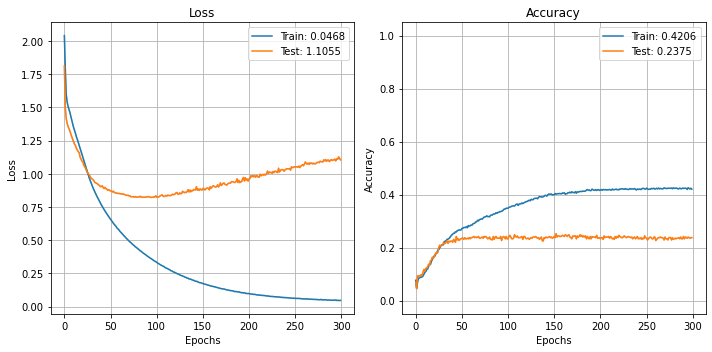

In [ ]:

from plot_keras_history import plot_history
plot_history(hist)

In [ ]:
#We are ready for inference. 
#(kopi o <pad> <pad> <pad>)	---------> ($START black coffee with sugar END$)
  ##Encoder(kopi o <pad> <pad> <pad>) = (h0,c0)
    ##(h0,c0) +  $START ----decoder-----> (black,  (h1,c1)) 
    ##(h1,c1)	+  black -----decoder---->  (coffee, (h2,c2))
    ##(h2,c2)	+  coffee ----decoder-----> (with,   (h3,c3))
    ##(h3,c3)	+  with ------decoder--->   (sugar,  (h4,c4))
    ##(h4,c4)	+  sugar -----decoder---->  (END$,   (h5,c5))


#To decode a test sentence, we will repeatedly:
#1) Encode the input sentence and retrieve the initial state (encoder_states = [state_h, state_c])
        ##(kopi o)--->encoder_states = [state_h, state_c]
#2) Run one step of the decoder ([state_h, state_c] + START_ -----> black)
    #initial state(encoder_states = [state_h, state_c]) and a "START_" token as input. 
    #The output will be the next Target_Word (may or maynot be "black").
#3) Append the Target_Word with previous input ("START_ Target_Word")  and REPEAT (utill "_END" predicted).

In [ ]:
#define encode_model seperatly as training stage 
#(kopi o)--->encoder_states = [state_h, state_c]
encoder_model = Model(encoder_inputs, encoder_states) #reusing the [encoder_inputs,encoder_states]
encoder_model.summary()

#define decoder_model seperatly as training stages
#[_h, _c] for decoder LSTM
decoder_state_input_h = Input(shape=(hidden_dim,))
decoder_state_input_c = Input(shape=(hidden_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# [(decoder_input->embed_layer), h_t0, c_t0] for decoder LSTM
decoder_outputs, state_h, state_c = decoder_lstm(de_x, initial_state=decoder_states_inputs)#reusing the decoder_lstm and de_x
# predict [h_t1, c_t1]
decoder_states = [state_h, state_c]
# predict [target_Seq_t1]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
decoder_model.summary()


Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, None)              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 64)          4032      
_________________________________________________________________
lstm_7 (LSTM)                [(None, 32), (None, 32),  12416     
Total params: 16,448
Trainable params: 16,448
Non-trainable params: 0
_________________________________________________________________
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, None)         0                                            
_____________________________________________________________________

In [ ]:
 ##Encoder(kopi o <pad> <pad> <pad>) = (h0,c0)
    ##(h0,c0) +  $START ----decoder-----> (black,  (h1,c1)) 
    ##(h1,c1)	+  black -----decoder---->  (coffee, (h2,c2))
    ##(h2,c2)	+  coffee ----decoder-----> (with,   (h3,c3))
    ##(h3,c3)	+  with ------decoder--->   (sugar,  (h4,c4))
    ##(h4,c4)	+  sugar -----decoder---->  (END$,   (h5,c5))

def decode_sequence(input_seq,num_decoder_tokens,encoder_model,decoder_model,vocab_B,max_decoder_seq_length):

    if len(input_seq)==0:
        return [vocab_B['end$']]
    # Encode the input as state vectors.
    ##Encoder(kopi o <pad> <pad> <pad>) = (h0,c0)
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of word_token.
    target_seq = np.zeros((1, 1))
    # Initialize with $start
    target_seq[0, 0] = vocab_B['$start']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1 (greedy decoding)).
    stop_condition = False
    decoded_word_index = []
    
    while not stop_condition:
        ##(h0,c0) +  $START ----decoder-----> (???,  (h1,c1)) 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Predict the best token (black)
        predict_token_index = np.argmax(output_tokens[0, -1, :])
        decoded_word_index.append(predict_token_index)

        # Exit condition: either hit max length # or find stop character.
        if (predict_token_index == vocab_B['end$'] or
           len(decoded_word_index) > max_decoder_seq_length):
            stop_condition = True

        ##(h1,c1)	+  black -----decoder---->  (???, (h2,c2))

        # Update the target sequence to the predict word_token
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predict_token_index
        # Update states
        states_value = [h, c]

    return decoded_word_index

In [ ]:
def decode_sequence(input_seq,num_decoder_tokens,encoder_model,decoder_model,vocab_B,max_decoder_seq_length):

    if len(input_seq)==0:
        return [vocab_B['end$']]
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of word_token.
    target_seq = np.zeros((1, 1))
    # Initialize with $start
    target_seq[0, 0] = vocab_B['$start']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1 (greedy decoding)).
    stop_condition = False
    decoded_word_index = []
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Predict a token
        predict_token_index = np.argmax(output_tokens[0, -1, :])
        decoded_word_index.append(predict_token_index)

        # Exit condition: either hit max length # or find stop character.
        if (predict_token_index == vocab_B['end$'] or
           len(decoded_word_index) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence to the predict word_token
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predict_token_index

        # Update states
        states_value = [h, c]

    return decoded_word_index

In [ ]:
#Try with the first row

print(seqA[0])
r = decode_sequence(seqA[0],vocab_size_B,encoder_model,decoder_model,word_index_B,maxlen_B)
print (r)


[1, 5]
[19, 12, 5, 14, 8, 11, 6, 2]


In [ ]:
# Creating a reverse dictionary

reverse_word_map_A = dict(map(reversed, tokenizer_A.word_index.items()))
reverse_word_map_B = dict(map(reversed, tokenizer_B.word_index.items()))

# Function takes a tokenized sentence and returns the words
def indexSeq_to_text_A(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map_A.get(letter) for letter in list_of_indices]
    return(words)

def indexSeq_to_text_B(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map_B.get(letter) for letter in list_of_indices]
    return(words)

print(indexSeq_to_text_A(seqA[0]))
print(indexSeq_to_text_B(r))

['kopi', 'kosong']
['iced', 'black', 'coffee', 'powder', 'and', 'more', 'sugar', 'end$']


In [ ]:
#Translater for a list of seqA to seqB     
def testSeq2Sq(listOfSeqA):
    listOfSeqB=[]
    token_seqA = tokenizer_A.texts_to_sequences(listOfSeqA)
    
    for a in token_seqA:
        r = decode_sequence(a,vocab_size_B,encoder_model,decoder_model,word_index_B,maxlen_B)
        tokens_b = indexSeq_to_text_B(r)
        sentB = ' '.join(tokens_b)
        listOfSeqB.append(sentB)
        
    return listOfSeqB

In [ ]:
#test with fresh data

decode_testSeqB = testSeq2Sq(testlines.SeqA)
testlines['Translated'] = decode_testSeqB
testlines.head()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,SeqA,SeqB,Translated
13,kopi gau peng,$START strong iced coffee with condensed milk ...,iced black coffee powder and more sugar end$
159,teh c,$START tea with evaporated milk and sugar END$,iced milk black coffee with sugar end$
69,diao yu,$START chinese tea END$,chinese tea end$
148,kopi gau,$START strong brew of coffee with condensed mi...,iced black coffee powder and more sugar end$
44,kopi o gau siew dai,$START hot black coffee with more coffee powde...,iced black coffee powder and more sugar end$


In [ ]:
#test with known training data
sample_train=lines[:10]
decode_sample_train = testSeq2Sq(sample_train.SeqA)
sample_train['Translated'] = decode_sample_train
sample_train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,SeqA,SeqB,Translated
3,kopi kosong,$START black coffee without sugar or milk END$,iced black coffee powder and more sugar end$
9,kopi gau,$START strong coffee with condensed milk END$,iced black coffee powder and more sugar end$
161,teh o,$START tea with sugar only END$,iced milk black coffee with sugar end$
2,kopi c,$START black coffee with evaporated milk END$,iced black coffee powder and more sugar end$
25,kopi gau ga dai,$START hot coffee with condensed milk and more...,iced black coffee powder and more sugar end$
